In [ ]:
import sys
from pathlib import Path

# Add nuctool directory to path for imports
nuctool_path = Path.cwd().parent / 'nuctool'
if str(nuctool_path) not in sys.path:
    sys.path.insert(0, str(nuctool_path))

import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm import tqdm

from ChromatinFibers import (
    convert_to_footprints,
    fetch_chromosome_sequence,
    ChromatinFiber,
)
from Plotter import Plotter, plot_sequence, plot_footprints
from pycorrelate import pcorrelate

plot = Plotter()
FILEOUT = rf"figures/SimulateYeastFibers.jpg"

In [2]:
chromosome = fetch_chromosome_sequence(r".genomes/sacCer3/sacCer3.fa", chromosome="II")
length = 10_000
locus_start = np.random.randint(0, len(chromosome) - length)
locus_sequence = chromosome[locus_start : locus_start + length]
fiber = ChromatinFiber(sequence=locus_sequence, start=locus_start)
fiber.fetch_orfs_by_range(start=locus_start, end=locus_start + length, chromosome="II")


ic| str(filename.| str(filename.parent): '.genomes\\sacCer3'
parent): '.genomes\\sacCer3'


Selected chromosome: chrII  len=813184


Saved figure: figures/SimulateYeastFibers_1.jpg


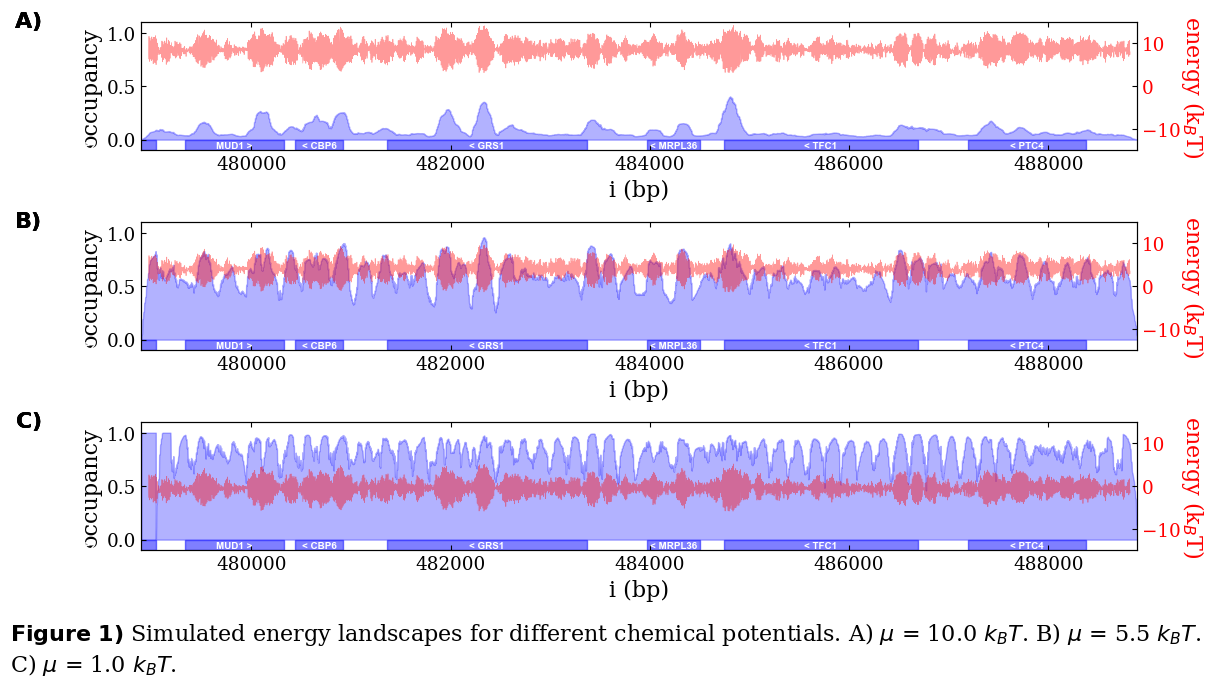

In [3]:
mus = np.linspace(10.0, 1.0, 3)

plot.new(fig_size=(12, 2*len(mus)), nrows = len(mus), ncols=1)
for i, panel in enumerate(plot.panels):
    panel.set_title(f"$\\mu$ = {mus[i]} $k_BT$")
    fiber.calc_energy_landscape(amplitude=0.05, period=9.7, chemical_potential=mus[i])
    plot_sequence(panel, fiber, energy=True, orfs=True)

plot.caption("Simulated energy landscapes for different chemical potentials.", filename=FILEOUT)

Sampling fibers and calculating methylation:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling fibers and calculating methylation: 100%|██████████| 50/50 [00:01<00:00, 28.26it/s]



Saved figure: figures/SimulateYeastFibers_2.jpg


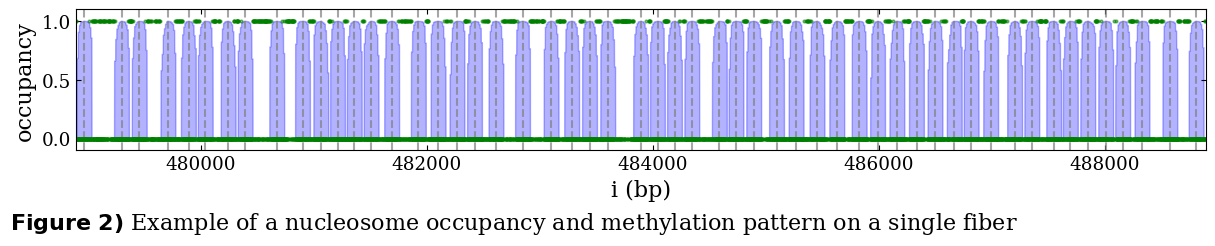

In [4]:
n = 50
methylated = []
for i in tqdm(range(n), desc="Sampling fibers and calculating methylation"):
    dyads = fiber.sample_fiber_configuration()
    methylation = fiber.calc_methylation(
        dyads, efficiency=0.4, e_contact=-0.8, steric_exclusion=0
    )
    methylated.append(methylation.methylated)

plot.new(fig_size=(12, 2))
plot_sequence(plot.panels[0], fiber, dyads=dyads, occupancy=methylation.protected, methylation=methylation.methylated)
plot.caption(
    "Example of a nucleosome occupancy and methylation pattern on a single fiber"
, filename=FILEOUT)


Saved figure: figures/SimulateYeastFibers_3.jpg


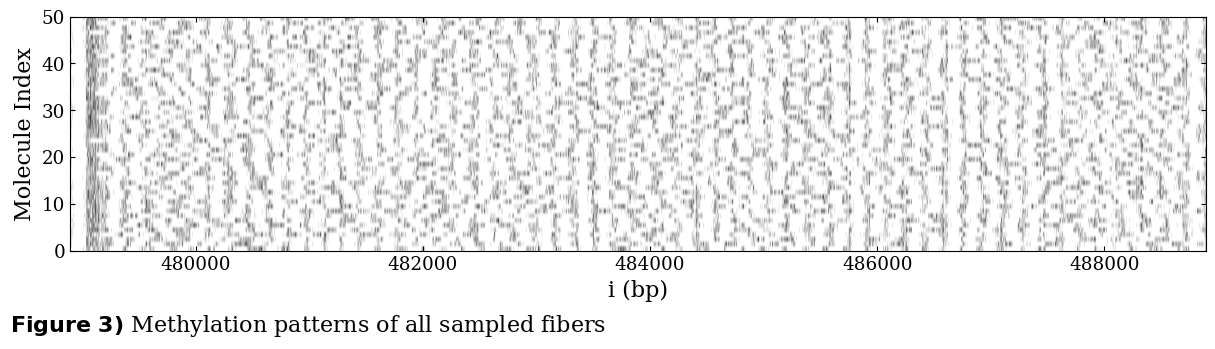

In [5]:
plot.new(fig_size=(12, 3))
plt.imshow(
    np.asarray(methylated) == 1,
    aspect="auto",
    cmap="Greys",
    extent=(
        fiber.index[0].astype(float),
        fiber.index[-1].astype(float),
        0,
        len(methylated),
    ),
)
plt.xlabel("i (bp)")
plt.ylabel("Molecule Index")

plot.caption("Methylation patterns of all sampled fibers", filename=FILEOUT)


Plotting footprints: 50it [00:04, 10.46it/s]



Saved figure: figures/SimulateYeastFibers_4.jpg


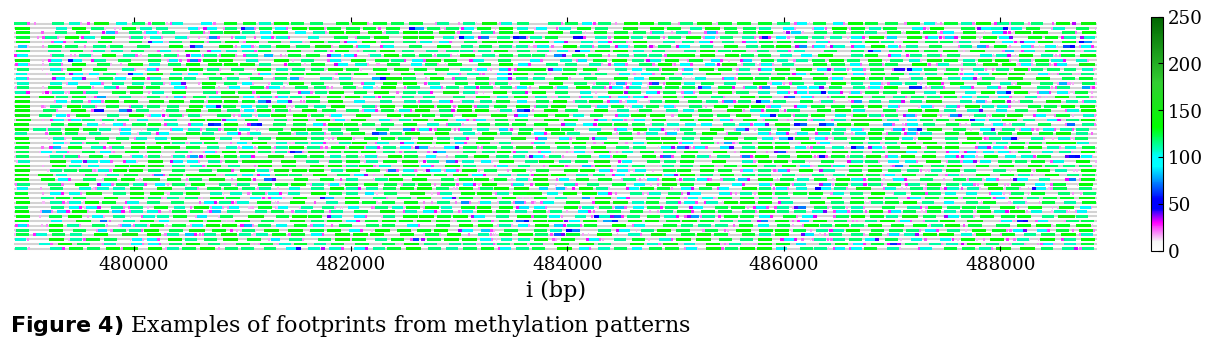

In [6]:
footprints = convert_to_footprints(methylated, fiber.index, minimal_footprint=15)

plot.new(fig_size=(12, 3))
plot_footprints(plot.panels[0], footprints, fiber.index, n_max=50)

plot.caption("Examples of footprints from methylation patterns", filename=FILEOUT)


Calculating correlation: 100%|██████████| 50/50 [00:05<00:00,  8.46it/s]



Saved figure: figures/SimulateYeastFibers_5.jpg


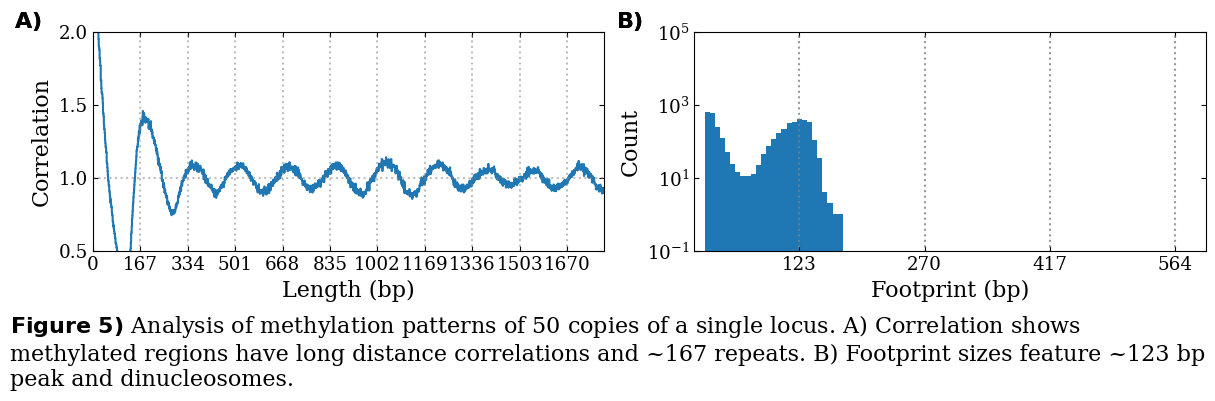

In [7]:
def analyze_footprints(methylated: np.ndarray, show = False) -> None:

    bins = np.arange(0, 1801, 1).astype(float)
    correlation = np.zeros_like(bins[:-1])

    for m in tqdm(methylated, desc="Calculating correlation"):
        t = fiber.index.astype(float)[np.where(m == 1)]
        correlation += pcorrelate(t, t, bins, normalize=True)

    footprints = convert_to_footprints(methylated, fiber.index, minimal_footprint=15)

    if show:
        plot.new(fig_size=(12, 3), ncols=2, fig_num=5)
        vlines = np.arange(0, np.max(bins).astype(int), 167)

        panel = plot.panels[0]
        panel.plot(bins[:-1], correlation / len(methylated), drawstyle="steps-post")

        panel.set_xticks(vlines, labels=[str(x) for x in vlines])
        panel.vlines(vlines, ymin=0, ymax=2, colors="gray", linestyles="dotted", alpha=0.5)
        panel.hlines(1, xmin=0, xmax=np.max(bins), colors="gray", linestyles="dotted", alpha=0.5)
        panel.set_xlim(0, np.max(bins))
        panel.set_xlabel("Length (bp)")
        panel.set_ylabel("Correlation")
        panel.set_ylim(0.5, 2)
        panel.set_title("Correlation shows methylated regions have long distance correlations and ~167 repeats.")

        # go to second figure
        panel = plot.panels[1]
        maxwidth = 600
        panel.set_xlim(0, maxwidth)
        panel.hist(footprints["width"].values, bins=100, range=(0, maxwidth))
        panel.set_xlabel("Footprint (bp)")
        panel.set_ylabel("Count")
        panel.set_ylim(1e-1, 1e5)
        xticks = np.arange(0, maxwidth, 147) - 24
        panel.set_xticks(xticks, labels=[str(x) for x in xticks])
        panel.vlines(
            xticks,
            ymin=0,
            ymax=panel.get_ylim()[1],
            colors="gray",
            linestyles="dotted",
            alpha=0.8,
        )
        panel.set_xlim(0, maxwidth)
        panel.set_yscale("log")
        panel.set_title(f"Footprint sizes feature ~123 bp peak and dinucleosomes.")

    return correlation, footprints

correlation, footprints = analyze_footprints(methylated, show=True)
plot.caption(f"Analysis of methylation patterns of {len(methylated)} copies of a single locus."
    , filename=FILEOUT
)


In [ ]:
chromosome = fetch_chromosome_sequence(r".genomes/sacCer3/sacCer3.fa", chromosome="II")

# Parameters for sampling the genomic loci
length = 10_000
n_loci = 50
n_reads = 100

# Parameters for nucleosome energy landscape
amplitude = 0.07
period = 9.8
mu = -1.0

# Parameters for methylation
efficiency = 0.4
e_contact = -0.5
steric_exclusion = 5

methylated = []


for _ in tqdm(range(n_loci), desc="Processing multiple loci"):
    locus_start = np.random.randint(0, len(chromosome) - length)
    locus_sequence = chromosome[locus_start : locus_start + length]
    fiber = ChromatinFiber(sequence=locus_sequence, start=locus_start)
    fiber.calc_energy_landscape(amplitude=amplitude, period=period, chemical_potential=mu)
    
    for i in range(n_reads):
        dyads = fiber.sample_fiber_configuration()
        methylation = fiber.calc_methylation(
            dyads, efficiency=efficiency, e_contact=e_contact, steric_exclusion=steric_exclusion
        )
        methylated.append(methylation.methylated)
        
correlation, footprints = analyze_footprints(methylated, show=True)

plot.caption(
    f"Footprint analysis of {len(methylated)} reads from {n_loci} random loci. ",
    filename=FILEOUT
)


ic| str(filename.parent| str(filename.parent): '.genomes\\sacCer3'
): '.genomes\\sacCer3'


Selected chromosome: chrII  len=813184


Processing multiple loci:  48%|████▊     | 24/50 [02:53<03:20,  7.69s/it]